# Challenge 1

In [22]:
string = '49276d206b696c6c696e6720796f757220627261696e206c696b65206120706f69736f6e6f7573206d757368726f6f6d'
result = b'SSdtIGtpbGxpbmcgeW91ciBicmFpbiBsaWtlIGEgcG9pc29ub3VzIG11c2hyb29t'

In [17]:
import base64
def hex2base64(x: str) -> str:
    x = bytes.fromhex(x)
    x = base64.b64encode(x)
    return x

In [23]:
hex2base64(string) == result

True

# Challenge 2

In [25]:
string = '1c0111001f010100061a024b53535009181c'
xorAgainst = '686974207468652062756c6c277320657965'
result = '746865206b696420646f6e277420706c6179'

In [94]:
def xor(a, b):
    return bytes([a_ ^ b_ for a_, b_ in zip(a,b)])

In [149]:
xor(bytes.fromhex(string), bytes.fromhex(xorAgainst)) == bytes.fromhex(result)

True

# Challenge 3

In [351]:
x = '1b37373331363f78151b7f2b783431333d78397828372d363c78373e783a393b3736'

In [90]:
# Create our own char probability distribution with the book MobyDick

import string
from collections import Counter

possible_characters = string.ascii_letters+string.digits+string.punctuation+' \n'
with open('./mobydick.txt', 'r') as f:
    file = f.read()
    file = ''.join([c for c in file if c in possible_characters])

counts = Counter(file)
letterFreq= {count[0].encode(): count[1]/len(file)  for count in counts.most_common() if count[1] >= 10}

In [91]:
def get_score(x, letterFreq):
    len_cyphertext = len(x)
    bytesFreq = {int.to_bytes(k, 1, byteorder='big').lower(): v/len_cyphertext for k, v in Counter(x).items()}
    freqDiff = 0
    for byte, byteFreq in bytesFreq.items():
        if byte in letterFreq:
            freqDiff += abs(letterFreq[byte] - byteFreq)**2
        else:
            freqDiff += 1
    return freqDiff/len(bytesFreq)

In [92]:
def crack(x, letterFreq, tryLuck=False):
    shape_text = len(x)
    all_possible_bytes = [int.to_bytes(i, length=1, byteorder='big') for i in range(256)]
    
    if tryLuck:
        min_ = 1
        for byte in all_possible_bytes:
            key = byte*shape_text
            xored = xor(x, key)
            score = get_score(xored, letterFreq)
            if score < min_:
                min_ = score
                results = {xored: (score, key)}
    else:
        results = {}
        for byte in all_possible_bytes:
            key = byte*shape_text
            xored = xor(x, key)
            results[xored] = (get_score(xored, letterFreq), key)
            results = dict(sorted(results.items(), key=lambda item: item[1][0]))
    return results

In [432]:
results = crack(bytes.fromhex(x), letterFreq)

In [433]:
{k: results[k] for k in list(results.keys())[:3]} 

{b"Cooking MC's like a pound of bacon": (0.056582447989728224,
  b'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'),
 b'iEEACDM\ngi\rY\nFCAO\nK\nZE_DN\nEL\nHKIED': (0.05777729241827566,
  b'rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr'),
 b'Ieeacdm*GI-y*fcao*k*ze\x7fdn*el*hkied': (0.05810824702862019,
  b'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR')}

# Challenge 4

In [434]:
with open('./cryptopals.com_static_challenge-data_4.txt', mode='r') as f:
    file = f.read().split('\n')

In [435]:
plain_texts = {}
for cyphertext in file:
    cyphertext = bytes.fromhex(cyphertext)
    results = crack(cyphertext, letterFreq, tryLuck=True)
    plain_texts[list(results.keys())[0]] = [cyphertext] + list(list(results.values())[0])
    # for key, value in {k: results[k] for k in list(results.keys())[:2]}.items():
    #     plain_texts[key] = [cyphertext] + list(value)

In [436]:
plain_texts = dict(sorted(plain_texts.items(), key=lambda item: item[1][1]))

In [439]:
{k: plain_texts[k] for k in list(plain_texts.keys())[:3]} 

{b'Now that the party is jumping\n': [b'{ZB\x15A]TA\x15A]P\x15ETGAL\x15\\F\x15_@XE\\[R?',
  0.0008405288816178472,
  b'555555555555555555555555555555'],
 b'S5_In*Z6uSN^eW(95gh""ZS2MhijvF': [b'7Q;-\nN>R\x117*:\x013L]Q\x03\x0cFF>7V)\x0c\r\x0e\x12"',
  0.04682201436678573,
  b'dddddddddddddddddddddddddddddd'],
 b"6GXyf\x821_6O't6-194u5DbH wi7vwef": [b'Q ?\x1e\x01\xe5V8Q(@\x13QJV^S\x12R#\x05/G\x10\x0eP\x11\x10\x02\x01',
  0.08206291755168774,
  b'gggggggggggggggggggggggggggggg']}

# Challenge 5

In [469]:
plainText = '''Burning 'em, if you ain't quick and nimble
I go crazy when I hear a cymbal'''
key = 'ICE'

ciphertext = '0b3637272a2b2e63622c2e69692a23693a2a3c6324202d623d63343c2a26226324272765272a282b2f20430a652e2c652a3124333a653e2b2027630c692b20283165286326302e27282f'

In [101]:
def repeatingKeyXOR(x, key):
    xlen = len(x)
    repKey = key*xlen
    return xor(x, repKey)

In [472]:
repeatingKeyXOR(plainText.encode(), key.encode()).hex() == ciphertext

True

In [475]:
print(repeatingKeyXOR(bytes.fromhex(ciphertext), key.encode()).decode())

Burning 'em, if you ain't quick and nimble
I go crazy when I hear a cymbal


# Challenge 6

In [104]:
import base64
with open('./cryptopals.com_static_challenge-data_6.txt', 'r') as f:
    file = base64.b64decode(f.read().replace('\n', '').encode())

In [10]:
a = 'this is a test'
b = 'wokka wokka!!!'

def hamming(x, y):
    assert len(x)==len(y), 'x and y should have the same length'
    x = [int(bit) for byte in x for bit in bin(byte)[2:].rjust(8, '0')]
    y = [int(bit) for byte in y for bit in bin(byte)[2:].rjust(8, '0')]
    return sum([x_!=y_ for x_, y_ in zip (x, y)])

print(hamming(a.encode(), b.encode()))

37


In [31]:
import math
from itertools import combinations

def guess_keysize(file, nChunks):
    average_over = math.factorial(nChunks)/(2*math.factorial(nChunks-2))
    scores = []
    min_ = 2**8*40
    guessed_keysize = None
    for keysize in range(2, 40):
        chunks = [file[i*keysize:(i + 1)*keysize] for i in range(nChunks)]
        score = sum([hamming(comb[0], comb[1])/keysize 
                    for comb in combinations(chunks, 2)]) / average_over
        scores.append(score)
        if score < min_:
            guessed_keysize = keysize
            min_ = score
    return scores, guessed_keysize

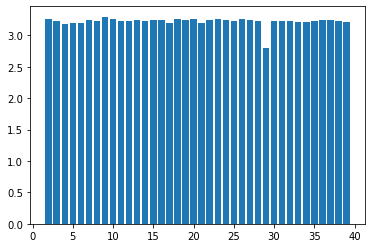

In [40]:
import matplotlib.pyplot as plt

scores, keysize = guess_keysize(file, nChunks=20)
plt.bar(range(2,40), scores);

In [88]:
import numpy as np

file_blocks = [file[i:keysize+i] for i in range(0, len(file), keysize)]
file_blocks[-1] = file_blocks[-1].ljust(keysize, b'\x00')
file_blocks_T = list(map(list, zip(*[[bytes([i]) for i in block] for block in file_blocks])))
file_blocks_T = [b''.join(block) for block in file_blocks_T]

In [100]:
key = b''
for cyphertext in file_blocks_T:
    results = crack(cyphertext, letterFreq, tryLuck=True)
    key+= bytes([list(results.values())[0][1][0]])
key

b'Terminator X: Bring the noise'

In [107]:
print(repeatingKeyXOR(file, key).decode())

I'm back and I'm ringin' the bell 
A rockin' on the mike while the fly girls yell 
In ecstasy in the back of me 
Well that's my DJ Deshay cuttin' all them Z's 
Hittin' hard and the girlies goin' crazy 
Vanilla's on the mike, man I'm not lazy. 

I'm lettin' my drug kick in 
It controls my mouth and I begin 
To just let it flow, let my concepts go 
My posse's to the side yellin', Go Vanilla Go! 

Smooth 'cause that's the way I will be 
And if you don't give a damn, then 
Why you starin' at me 
So get off 'cause I control the stage 
There's no dissin' allowed 
I'm in my own phase 
The girlies sa y they love me and that is ok 
And I can dance better than any kid n' play 

Stage 2 -- Yea the one ya' wanna listen to 
It's off my head so let the beat play through 
So I can funk it up and make it sound good 
1-2-3 Yo -- Knock on some wood 
For good luck, I like my rhymes atrocious 
Supercalafragilisticexpialidocious 
I'm an effect and that you can bet 
I can take a fly girl and make her wet. 


# 7

In [8]:
key = 'YELLOW SUBMARINE'
with open('./cryptopals.com_static_challenge-data_7.txt', 'r') as f:
    file = ''.join(f.read().split('\n'))

In [11]:
import base64
fileb64d = base64.b64decode(file.encode())

In [23]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes

cipher = Cipher(
    algorithm=algorithms.AES(key.encode()),
    mode=modes.ECB()
    )
decryptor = cipher.decryptor()

In [31]:
plain_text = decryptor.update(fileb64d).decode()
print(plain_text)

I'm back and I'm ringin' the bell 
A rockin' on the mike while the fly girls yell 
In ecstasy in the back of me 
Well that's my DJ Deshay cuttin' all them Z's 
Hittin' hard and the girlies goin' crazy 
Vanilla's on the mike, man I'm not lazy. 

I'm lettin' my drug kick in 
It controls my mouth and I begin 
To just let it flow, let my concepts go 
My posse's to the side yellin', Go Vanilla Go! 

Smooth 'cause that's the way I will be 
And if you don't give a damn, then 
Why you starin' at me 
So get off 'cause I control the stage 
There's no dissin' allowed 
I'm in my own phase 
The girlies sa y they love me and that is ok 
And I can dance better than any kid n' play 

Stage 2 -- Yea the one ya' wanna listen to 
It's off my head so let the beat play through 
So I can funk it up and make it sound good 
1-2-3 Yo -- Knock on some wood 
For good luck, I like my rhymes atrocious 
Supercalafragilisticexpialidocious 
I'm an effect and that you can bet 
I can take a fly girl and make her wet. 


# 8

In [36]:
with open('./cryptopals.com_static_challenge-data_8.txt', 'r') as f:
    file = f.read().split('\n')
decoded_file = [bytes.fromhex(text) for text in file]

In [41]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes

cipher = Cipher(
    algorithm=algorithms.AES(key.encode()),
    mode=modes.ECB()
    )
decryptor = cipher.decryptor()

In [54]:
[segment in segments8bytes for segment in segments8bytes]

[True, True, True, True, True, True, True, True, True, True]

In [55]:
nBytesCipher = 16

ECBmodeDetected = []
for text in decoded_file:
    plain_text = decryptor.update(text)
    segments8bytes = [text[i:i+nBytesCipher] for i in range(0, len(text), nBytesCipher)]
    if len(segments8bytes) != len(set(segments8bytes)):
        ECBmodeDetected.append(text)

In [59]:
print([i.hex() for i in ECBmodeDetected])

['d880619740a8a19b7840a8a31c810a3d08649af70dc06f4fd5d2d69c744cd283e2dd052f6b641dbf9d11b0348542bb5708649af70dc06f4fd5d2d69c744cd2839475c9dfdbc1d46597949d9c7e82bf5a08649af70dc06f4fd5d2d69c744cd28397a93eab8d6aecd566489154789a6b0308649af70dc06f4fd5d2d69c744cd283d403180c98c8f6db1f2a3f9c4040deb0ab51b29933f2c123c58386b06fba186a']
